In [1]:
import numpy as np
import torch
# import colorspaces
import matplotlib.pyplot as plt

# data = np.load("../data/ae_data.npz") #Load data
data = np.load("/content/drive/MyDrive/HW04/data/ae_data.npz")

#Extract train data
RGBtr = torch.tensor(data["RGBtr"])
Ltr   = torch.tensor(data["Ltr"])
ABtr  = torch.tensor(data["ABtr"])

print("RGBtr shape = ", RGBtr.shape)
print("Ltr shape = ", Ltr.shape)
print("ABtr shape = ", ABtr.shape)

#Extract test data
RGBte = torch.tensor(data["RGBte"])
Lte   = torch.tensor(data["Lte"])
ABte  = torch.tensor(data["ABte"])

print("RGBte shape = ", RGBte.shape)
print("Lte shape = ", Lte.shape)
print("ABte shape = ", ABte.shape)

RGBtr shape =  torch.Size([50000, 32, 32, 3])
Ltr shape =  torch.Size([50000, 32, 32])
ABtr shape =  torch.Size([50000, 32, 32, 2])
RGBte shape =  torch.Size([10, 32, 32, 3])
Lte shape =  torch.Size([10, 32, 32])
ABte shape =  torch.Size([10, 32, 32, 2])


In [2]:
#LAB-RGB conversions
import torchvision
import torch

def preprocess_lab(lab):
		# L_chan: black and white with input range [0, 100]
		# a_chan/b_chan: color channels with input range ~[-110, 110], not exact
		# [0, 100] => [-1, 1],  ~[-110, 110] => [-1, 1]
		scale = torch.tensor([50,110,110]).reshape([1,1,1,3])
		offset = torch.tensor([-1,0,0]).reshape([1,1,1,3])
		return lab/scale + offset

def deprocess_lab(labp):
		scale = torch.tensor([50,110,110]).reshape([1,1,1,3])
		offset = torch.tensor([-1,0,0]).reshape([1,1,1,3])
		lab = (labp - offset)*scale
		return lab

def rgb_to_lab(srgb):

	srgb_pixels = torch.reshape(srgb, [-1, 3])

	linear_mask = (srgb_pixels <= 0.04045).type(torch.FloatTensor)
	exponential_mask = (srgb_pixels > 0.04045).type(torch.FloatTensor)
	rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask

	rgb_to_xyz = torch.tensor([
				#    X        Y          Z
				[0.412453, 0.212671, 0.019334], # R
				[0.357580, 0.715160, 0.119193], # G
				[0.180423, 0.072169, 0.950227], # B
			]).type(torch.FloatTensor)

	xyz_pixels = torch.mm(rgb_pixels, rgb_to_xyz)


	# XYZ to Lab
	xyz_normalized_pixels = torch.mul(xyz_pixels, torch.tensor([1/0.950456, 1.0, 1/1.088754]).type(torch.FloatTensor))

	epsilon = 6.0/29.0

	linear_mask = (xyz_normalized_pixels <= (epsilon**3)).type(torch.FloatTensor)

	exponential_mask = (xyz_normalized_pixels > (epsilon**3)).type(torch.FloatTensor)

	fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4.0/29.0) * linear_mask + ((xyz_normalized_pixels+0.000001) ** (1.0/3.0)) * exponential_mask
	# convert to lab
	fxfyfz_to_lab = torch.tensor([
		#  l       a       b
		[  0.0,  500.0,    0.0], # fx
		[116.0, -500.0,  200.0], # fy
		[  0.0,    0.0, -200.0], # fz
	]).type(torch.FloatTensor)
	lab_pixels = torch.mm(fxfyfz_pixels, fxfyfz_to_lab) + torch.tensor([-16.0, 0.0, 0.0]).type(torch.FloatTensor)
	#return tf.reshape(lab_pixels, tf.shape(srgb))
	return preprocess_lab(torch.reshape(lab_pixels, srgb.shape))

def lab_to_rgb(labp):
		lab = deprocess_lab(labp)
		lab_pixels = torch.reshape(lab, [-1, 3])
		# convert to fxfyfz
		lab_to_fxfyfz = torch.tensor([
			#   fx      fy        fz
			[1/116.0, 1/116.0,  1/116.0], # l
			[1/500.0,     0.0,      0.0], # a
			[    0.0,     0.0, -1/200.0], # b
		]).type(torch.FloatTensor)
		fxfyfz_pixels = torch.mm(lab_pixels + torch.tensor([16.0, 0.0, 0.0]).type(torch.FloatTensor), lab_to_fxfyfz)

		# convert to xyz
		epsilon = 6.0/29.0
		linear_mask = (fxfyfz_pixels <= epsilon).type(torch.FloatTensor)
		exponential_mask = (fxfyfz_pixels > epsilon).type(torch.FloatTensor)


		xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29.0)) * linear_mask + ((fxfyfz_pixels+0.000001) ** 3) * exponential_mask

		# denormalize for D65 white point
		xyz_pixels = torch.mul(xyz_pixels, torch.tensor([0.950456, 1.0, 1.088754]).type(torch.FloatTensor))


		xyz_to_rgb = torch.tensor([
			#     r           g          b
			[ 3.2404542, -0.9692660,  0.0556434], # x
			[-1.5371385,  1.8760108, -0.2040259], # y
			[-0.4985314,  0.0415560,  1.0572252], # z
		]).type(torch.FloatTensor)

		rgb_pixels =  torch.mm(xyz_pixels, xyz_to_rgb)
		# avoid a slightly negative number messing up the conversion
		#clip
		rgb_pixels[rgb_pixels > 1] = 1
		rgb_pixels[rgb_pixels < 0] = 0

		linear_mask = (rgb_pixels <= 0.0031308).type(torch.FloatTensor)
		exponential_mask = (rgb_pixels > 0.0031308).type(torch.FloatTensor)
		srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + (((rgb_pixels+0.000001) ** (1/2.4) * 1.055) - 0.055) * exponential_mask

		srgb_pixels[srgb_pixels>1]=1
		srgb_pixels[srgb_pixels<0]=0

		return torch.reshape(srgb_pixels, lab.shape)

In [28]:
import math
import torch
import torch.nn.functional as F
# import numpy as np
# from torch.nn.utils.parametrizations import weight_norm

class nn(torch.nn.Module):

  def __init__(self):
    super(nn, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 8, 3)
    self.batch1 = torch.nn.BatchNorm2d(8)
    self.conv2 = torch.nn.Conv2d(8, 16, 3)
    self.batch2 = torch.nn.BatchNorm2d(16)
    self.conv3 = torch.nn.Conv2d(16, 16, 3)
    # self.batch3 = torch.nn.BatchNorm2d(32)
    self.conv4 = torch.nn.Conv2d(16, 16, 3)
    self.fc1 = torch.nn.Linear(24*24*16, 1024)

    self.fc2 = torch.nn.Linear(1024, 12*12*32)
    self.upsample = torch.nn.Upsample(scale_factor = 2, mode='nearest-exact')
    # self.upsample2 = torch.nn.Upsample(scale_factor = 1/2, mode='nearest-exact')
    self.conv5 = torch.nn.ConvTranspose2d(32, 8, 3)
    # self.conv6 = torch.nn.ConvTranspose2d(16, 8, 3)
    self.conv7 = torch.nn.ConvTranspose2d(8, 2, 5)
    self.PATH = '/content/drive/MyDrive/HW04/nn.pt'

    # torch.nn.init.xavier_uniform_(self.conv1.weight)
    # torch.nn.init.xavier_uniform_(self.conv2.weight)
    # # torch.nn.init.xavier_uniform_(self.conv3.weight)
    # # torch.nn.init.xavier_uniform_(self.conv4.weight)
    # torch.nn.init.xavier_uniform_(self.conv5.weight)
    # # torch.nn.init.xavier_uniform_(self.conv6.weight)
    # torch.nn.init.xavier_uniform_(self.conv7.weight)

  def f(self, L):
    L = L.reshape(-1, 1, 32, 32)
    L = F.leaky_relu(self.batch1(self.conv1(L)))
    L = F.leaky_relu(self.batch2(self.conv2(L)))
    # L = F.interpolate(L, scale_factor=1/2)
    L = F.leaky_relu(self.batch2(self.conv3(L)))
    L = F.leaky_relu(self.batch2(self.conv4(L)))
    # L = self.upsample2(L)
    L = torch.flatten(L, 1)
    L = self.fc1(L)
    return F.leaky_relu(L)

  def g(self, L):
    L = self.fc2(L)
    L = L.reshape(-1, 32, 12, 12)
    # L = self.upsample(L)
    # L = L.reshape(-1, 32, 8, 8)
    L = F.leaky_relu(self.batch1(self.conv5(L)))
    L = self.upsample(L)
    # L = F.leaky_relu(self.batch1(self.conv6(L)))
    L = self.conv7(L)
    # print("L shape = ", L.shape)
    return F.tanh(L)

  def loss(self, L, AB):
    # N = L.shape[0]
    AB_hat = self.predict(L).reshape(-1, 2, 32, 32)
    # diff = AB_hat-AB
    # loss = 1/N * torch.sum(torch.square(diff))
    loss = torch.nn.MSELoss()(AB_hat, AB)
    # print("AB_hat = ", AB_hat)
    # loss = torch.nn.L1Loss()(AB_hat, AB)
    return loss

  def fit(self, L, AB):
    # Defining hyper-parameters
    learning_rate = 0.00001
    optimizer=torch.optim.AdamW(model.parameters(), learning_rate)
    batch_size = 1024
    N = L.shape[0]
    epochs = 10

    losses = []
    # prev_loss = np.infty
    for epoch in range(epochs):
      batch_idx = 0
      while True:
        optimizer.zero_grad()
        loss = self.loss(L[batch_idx:batch_idx+batch_size,:,:], AB[batch_idx:batch_idx+batch_size,:,:,:])
        loss.backward()
        optimizer.step()
        print(f"{epoch} {loss.item()}")
        # if (abs(loss.item()-prev_loss) <= conv_tol):
        #   break;
        # prev_loss = loss.item()
        if batch_idx+batch_size < N:
          batch_idx = (batch_idx+batch_size)
        else:
          batch_idx = 0
          break
        # batch_idx = (batch_idx+batch_size if batch_idx+batch_size < N else 0)

      with torch.no_grad():
        loss = self.loss(L, AB)
        print(f"Train Loss for the epoch {epoch} is {loss}")
        losses.append(loss)
      self.save()
    return losses

  def predict(self, L):
    encoded = self.f(L)
    decoded = self.g(encoded)
    return decoded.flatten(start_dim=1)

  def save(self):
    torch.save({"model_state_dict": self.state_dict()}, self.PATH)

  def load(self):
    checkpoint = torch.load(self.PATH, map_location=torch.device('cpu'))
    self.load_state_dict(checkpoint["model_state_dict"])

In [29]:
import torch
import matplotlib.pyplot as plt

def train(model, device, L, AB):

  # Randomly shuffle the training set
  idx = torch.randperm(L.shape[0])
  L_shuffled = L[idx, :, :]
  AB_shuffled = AB[idx, :, :, :]

  model.train()
  losses = model.fit(L_shuffled.to(device), AB_shuffled.to(device))
  return losses

def predict(model, device, L):
  model.eval()
  L = L.to(device)
  with torch.no_grad():
    return model.predict(L).reshape(-1, 2, 32, 32).permute([0, 2, 3, 1])

def test(pred_RGB, RGB):
  return torch.nn.MSELoss()(pred_RGB, RGB)

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

# Initialize the model and move the model and data to the device
model = nn().to(device)
model.load()

Ltr = Ltr.reshape([-1, 32, 32, 1]).permute([0, 3, 1, 2])
ABtr = ABtr.permute([0, 3, 1, 2])
Ltrain = Ltr[:49152,:,:,:]
ABtrain = ABtr[:49152,:,:,:]
Lval = Ltr[49152:,:,:,:]
ABval = ABtr[49152:,:,:,:]

# Train the model
losses = train(model, device, Ltrain, ABtrain)
x = range(len(losses))
plt.plot(x, losses)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.grid()

# Save the model params
model.save()

# Predict on the training set
pred_ABtr = predict(model, device, Ltr[:,:,:])
print("pred_ABtr shape = ", pred_ABtr.shape)
pred_LABtr = torch.cat((Ltr[:,:,:,None],pred_ABtr.to("cpu")),dim=3)
train_error = 0

plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBtr[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Ltr[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBtr = lab_to_rgb(pred_LABtr[i,:,:,:])
    train_error += test(pred_RGBtr, RGBtr)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBtr[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Train error
print("train error = ", train_error)

# Predict on the test set
pred_ABte = predict(model, device, Lte)
pred_LABte = torch.cat((Lte[:,:,:,None],pred_ABte.to("cpu")),dim=3)
test_error = 0

#Plot true and predicted RGB images
plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBte[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Lte[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBte = lab_to_rgb(pred_LABte[i,:,:,:])
    test_error += test(pred_RGBte, RGBte)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBte[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Test error
print("test error = ", test_error)

NameError: ignored

In [12]:
model.save()

pred_ABtr shape =  torch.Size([15, 32, 32, 2])


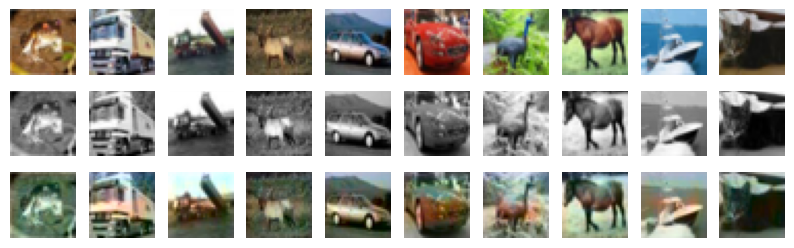

train error =  1.088521122932434


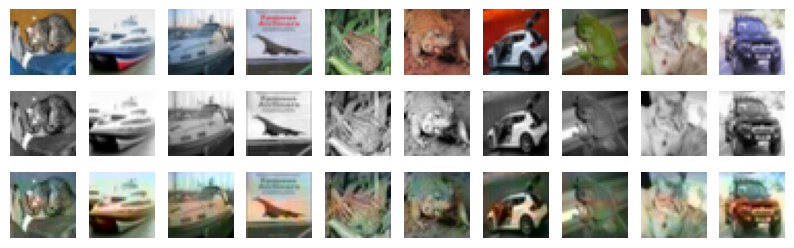

test error =  1.0125362873077393


In [31]:
# Predict on the training set
pred_ABtr = predict(model, device, Ltr[:15,:,:])
print("pred_ABtr shape = ", pred_ABtr.shape)
pred_LABtr = torch.cat((Ltr[:15,:,:,None],(pred_ABtr).to("cpu")),dim=3)
train_error = 0

plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBtr[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Ltr[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBtr = lab_to_rgb(pred_LABtr[i,:,:,:])
    train_error += test(pred_RGBtr, RGBtr)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBtr[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Train error
print("train error = ", torch.sqrt(train_error).item())

# Predict on the test set
pred_ABte = predict(model, device, Lte[:15,:,:])
pred_LABte = torch.cat((Lte[:15,:,:,None],(pred_ABte).to("cpu")),dim=3)
test_error = 0

#Plot true and predicted RGB images
plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBte[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Lte[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBte = lab_to_rgb(pred_LABte[i,:,:,:])
    test_error += test(pred_RGBte, RGBte)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBte[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Test error
print("test error = ", torch.sqrt(test_error).item())

In [ ]:
def read_losses(file_name):
  losses = []
  with open(file_name, 'r') as fp:
      for line in fp:
          x = line[:-1]
          losses.append(float(x))

  return losses

def write_losses(file_name, losses):
  with open(file_name, 'w') as fp:
    for item in losses:
        fp.write("%s\n" % item)

adadelta_file = "/content/drive/MyDrive/HW04/nn_adadelta_0.1.txt"
adagrad_file = "/content/drive/MyDrive/HW04/nn_adagrad_0.1.txt"
adam_file = "/content/drive/MyDrive/HW04/nn_adam_0.01.txt"
sgd_file = "/content/drive/MyDrive/HW04/nn_sgd.txt"
epoch_file1024_ = "/content/drive/MyDrive/HW04/nn_1024.txt"
epoch_file512_ = "/content/drive/MyDrive/HW04/nn_512.txt"
epoch_file2048_ = "/content/drive/MyDrive/HW04/nn_2048.txt"

In [ ]:
write_losses(epoch_file1024_, losses)

In [ ]:
loss_1024 = read_losses(epoch_file1024_)
print(loss_1024)
loss_512 = read_losses(epoch_file512_)
loss_2048 = read_losses(epoch_file2048_)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
x = np.arange(len(loss_512))
plt.plot(x, loss_512, label="Batch size = 512 (lr=0.001)", color='red', marker='o')
x = np.arange(len(loss_1024))
plt.plot(x, loss_1024, label="Batch size = 1024 (lr=0.001)", color='yellow', marker='|')
x = np.arange(len(loss_2048))
plt.plot(x, loss_2048, label="Batch size = 2048 (lr=0.001)", color='blue', marker='*')
plt.legend()
plt.grid()
plt.title("Gradient descent for different batch sizes for 5 epochs")
plt.xlabel("Iterations")
plt.ylabel("Loss")